In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50

In [3]:
cu_df= pd.read_csv("Data_Marketing_Customer_Analysis_Round3.csv")

numericals = cu_df.select_dtypes(include=[np.number])
categoricals = cu_df.select_dtypes(exclude=[np.number])

X = cu_df.drop('total_claim_amount', axis=1)
y = cu_df.total_claim_amount

numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(np.object)

/var/folders/n_/mqs2n84x0k3g_vz_3dbgh2yr0000gp/T/ipykernel_83689/1632068694.py:10: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categoricalX = X.select_dtypes(np.object)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(cu_df.drop('total_claim_amount', axis=1), cu_df['total_claim_amount'], test_size=0.2, random_state=42)


In [5]:
from scipy.stats import iqr
def remove_outliers(cu_df):
    for c in cu_df.columns:
            pct_75 = np.percentile(cu_df[c], 75)
            pct_25 = np.percentile(cu_df[c], 25)
            upper_bound = pct_75 + 1.5*iqr(cu_df[c])
            lower_bound = pct_25 - 1.5*iqr(cu_df[c])
            condition = (cu_df[c] < upper_bound) & (cu_df[c] > lower_bound)
            cu_df[c] = cu_df[c][condition]  # Filter out the outliers
    return cu_df

In [ ]:
X = pd.concat([pd.get_dummies(X[categoricalX.columns],drop_first=True),
               remove_outliers(X[numericalX.columns])],
              axis=1)

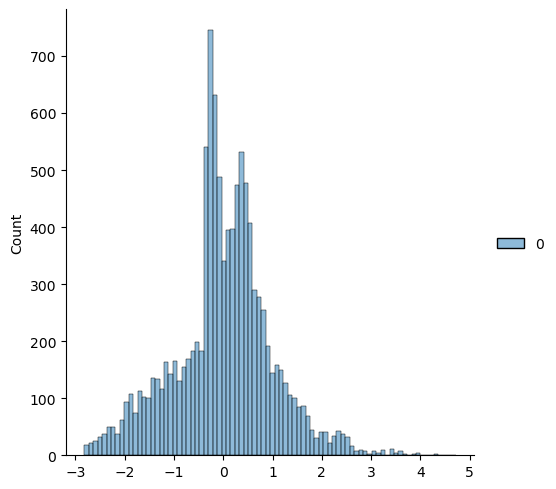

In [6]:

#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train_scaled = scaler.transform(X_train)
#X_test_scaled = scaler.transform(X_test)

pt = PowerTransformer()
totalclaim_transformed=pt.fit_transform(cu_df['total_claim_amount'].to_numpy().reshape(-1,1))
sns.displot(totalclaim_transformed)

In [7]:
ct = ColumnTransformer([("pt", pt, list(numericalX.columns))],
                        remainder='drop',verbose_feature_names_out=True,verbose=True).fit(X_train)
X_train_ct = pd.DataFrame(ct.transform(X_train),columns=ct.get_feature_names_out())
X_test_ct = pd.DataFrame(ct.transform(X_test),columns=ct.get_feature_names_out())

[ColumnTransformer] ............ (1 of 1) Processing pt, total=   0.1s


In [8]:
X_train = pd.DataFrame(X_train_ct)
X_test_ct

,pt__customer_lifetime_value,pt__income,pt__monthly_premium_auto,pt__months_since_last_claim,pt__months_since_policy_inception,pt__number_of_open_complaints,pt__number_of_policies
0,-0.313260,0.865977,-1.535708,-1.948892,1.036302,-0.504231,1.126951
1,0.678873,-0.257692,1.005081,-0.349713,1.036302,-0.504231,0.509194
2,-1.092136,0.721535,-0.161073,-1.948892,-0.016501,-0.504231,-1.148679
3,-0.245562,0.464816,-1.251406,0.579080,-2.088503,1.939188,0.509194
4,0.550119,-0.094361,2.002861,-1.116508,-0.927869,1.939188,-1.148679
...,...,...,...,...,...,...,...
2133,-0.852546,-1.825015,0.433657,1.386884,-0.641640,-0.504231,-1.148679
2134,0.525369,0.811961,0.713690,1.038512,-1.194401,-0.504231,0.509194
2135,-0.649299,1.230545,0.939407,-0.829156,0.886206,-0.504231,-1.148679
2136,0.326995,-0.700978,0.398393,0.326979,-0.228232,-0.504231,1.572580


In [9]:
X_train_const_ct = sm.add_constant(X_train_ct.to_numpy()) # adding a constant

model = sm.OLS(y_train, X_train_const_ct).fit()   #stats models is the sm 
predictions_train = model.predict(X_train_const_ct)

X_test_const_ct = sm.add_constant(X_test_ct) # adding a constant
predictions_test = model.predict(X_test_const_ct)
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     556.6
Date:                Wed, 12 Apr 2023   Prob (F-statistic):               0.00
Time:                        17:11:42   Log-Likelihood:                -59139.
No. Observations:                8551   AIC:                         1.183e+05
Df Residuals:                    8543   BIC:                         1.183e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        432.7827      2.640    163.959      0.0

In [10]:
model=LinearRegression()    # model
model.fit(X_train_ct, y_train)

LinearRegression()

In [11]:
y_pred = pd.DataFrame(model.predict(X_test_ct),columns = ['total_claim_amount'] )      # model prediction for test set
y_pred_train =  pd.DataFrame(model.predict(X_train_ct),columns = ['total_claim_amount'])

In [12]:
model.coef_

array([ -2.71614498, -36.29813171, 162.08426223,   2.07457984,
        -1.29805377,  -2.89204253,   0.96297564])

In [13]:
model.intercept_

432.78271547191827

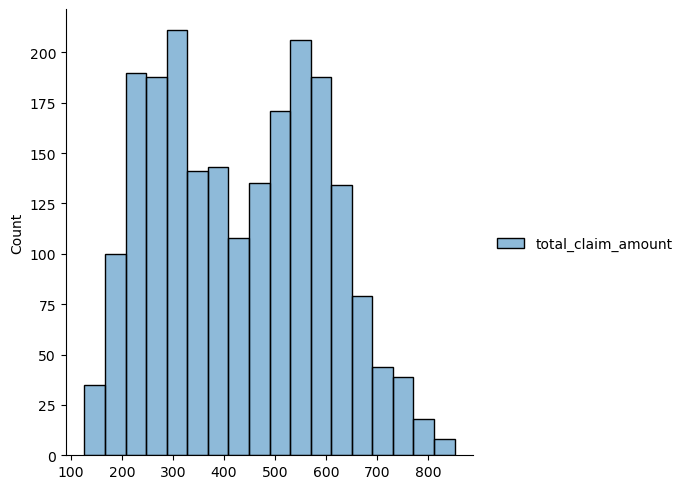

In [14]:
sns.displot(y_pred)

In [15]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))
##prediction on the train set
print(mse(y_train,y_pred_train))

56887.588063601776
166.09915795541707
59522.59631997504


In [16]:
R2=r2_score(y_test,y_pred)
R2

0.2992212238943517

In [17]:
R2_test=model.score(X_test_ct,y_test)
R2_train=model.score(X_train_ct,y_train)
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adj_R2

0.2915968568884718

In [18]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_.reshape(len(X_train.columns),))
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)
features_importances

,Attribute,Importance
2,pt__monthly_premium_auto,162.084262
1,pt__income,36.298132
5,pt__number_of_open_complaints,2.892043
0,pt__customer_lifetime_value,2.716145
3,pt__months_since_last_claim,2.074580
4,pt__months_since_policy_inception,1.298054
6,pt__number_of_policies,0.962976


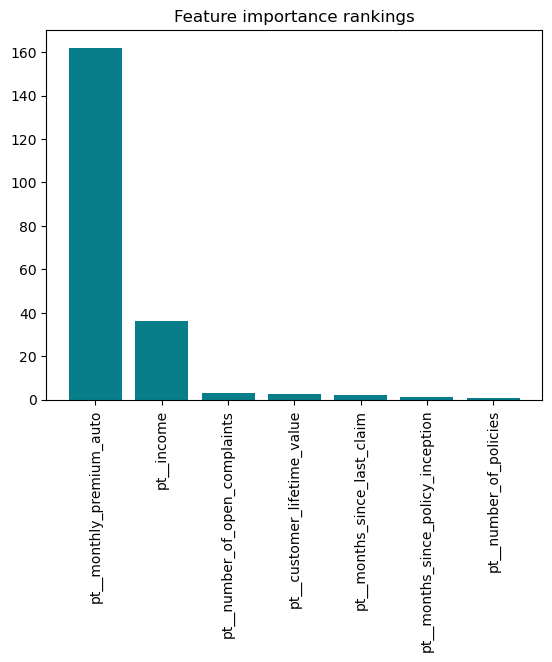

In [19]:
plt.bar(x=features_importances['Attribute'].iloc[:10], height=features_importances['Importance'].iloc[:10], color='#087E8B')
plt.title('Feature importance rankings', size=12)
plt.xticks(rotation='vertical')
plt.show()